### Set up

#### Installation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/MyDrive/Master’s Thesis/data/'

/content/drive/MyDrive/Kuliah/BDMA/Master’s Thesis/data


In [ ]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 36.8 MB/s eta 0:00:00


In [ ]:
!pip install pyproj

In [ ]:
!pip install wandb -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.8 MB/s eta 0:00:00


#### Import module

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import re
from tqdm import tqdm

import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from shapely.geometry import Point, LineString, Polygon
from datetime import timedelta
from pyproj import Transformer

from geopy.distance import geodesic
import numpy as np
import contextily as cx
import pyproj

from sklearn.metrics.pairwise import haversine_distances

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

In [ ]:
import wandb

In [ ]:
wandb.login(key='baa9bd51cff45b100a3b43f6a039845a468eb8b2')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

#### Sweep Configuration

In [ ]:
sweep_config = {
  'method': 'bayes'
}

metric = {
  'name': 'loss',
  'goal': 'minimize'
}

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['adam']
        },
    'lstm_layer_size': {
        'values': [150, 250, 300]
        },
    'lstm_layers': {
        'values': [1, 2, 3]
    },
    'dense_layer_size': {
      'values': [150]
    },
    'dropout': {
          'values': [0.2, 0.3, 0.4]
    },
    'activation': {
        'values': ['relu', 'prelu']
    }
    }

sweep_config['parameters'] = parameters_dict

parameters_dict.update({
    'epochs': {
        'value': 5
        }
    })

parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        "values": [0.0005, 0.001, 0.005]
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 32,
        'max': 512,
      }
    })

sweep_id = wandb.sweep(sweep_config, project="ais-sweeps")

import pprint
pprint.pprint(sweep_config)

Create sweep with ID: x7qez7fm
Sweep URL: https://wandb.ai/satriabw/ais-sweeps/sweeps/x7qez7fm
{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'activation': {'values': ['relu', 'prelu']},
                'batch_size': {'distribution': 'q_log_uniform_values',
                               'max': 512,
                               'min': 32,
                               'q': 8},
                'dense_layer_size': {'values': [150]},
                'dropout': {'values': [0.2, 0.3, 0.4]},
                'epochs': {'value': 5},
                'learning_rate': {'values': [0.0005, 0.001, 0.005]},
                'lstm_layer_size': {'values': [150, 250, 300]},
                'lstm_layers': {'values': [1, 2, 3]},
                'optimizer': {'values': ['adam']}}}


### Try to train the data into the LSTM model

##### Dataset Generator


In [ ]:
import random

# Function to generate random data
def generate_random_data(num_samples=10):
    data = {
        "t": pd.date_range(start="2023-09-30 22:01:00", periods=num_samples, freq='T').astype(str).tolist(),
        "mmsi_id": ["209075000_1"] * num_samples,
        "trip": [],
        "cog_x": [],
        "cog_y": [],
        "lat": [],
        "lon": [],
        "gaps": []
    }

    base_lat = 12.702365
    base_lon = 55.574631

    for i in range(num_samples):
        if i == 0:
            lat = base_lat
            lon = base_lon
            gap = 0.0
        else:
            lat = base_lat + random.uniform(-0.001, 0.001)
            lon = base_lon + random.uniform(-0.004, 0.004)
            gap = random.uniform(0.2, 0.3)

        trip_point = Point(lat, lon)
        cog_x = random.uniform(-5, -4)
        cog_y = random.uniform(0.2, 0.3)

        data["trip"].append(trip_point)
        data["cog_x"].append(cog_x)
        data["cog_y"].append(cog_y)
        data["lat"].append(lat)
        data["lon"].append(lon)
        data["gaps"].append(gap)

        base_lat = lat
        base_lon = lon

    return pd.DataFrame(data)

# Generate the dummy data
dataset = generate_random_data(15)

##### Dataset Preparation

In [ ]:
class TrajectoryDataset(Dataset):
    def __init__(self, df, columns=['lat', 'lon', 'speed', 'cog', 'gaps'],
                 group_attr="mmsi_id", sequence_length=30, prediction_steps=10, padde_value=999):
      self.columns = columns
      self.sequence_length = sequence_length
      self.group_attr = group_attr
      self.padded_value = 999
      self.X, self.y = self.__prepare_sequence__(df, sequence_length, prediction_steps, columns)

    def __create_sequence__(self, track_data, sequence_length, columns, prediction_steps):
      X, y = [], []

      # Ensure the track data is sorted
      track_data = track_data.sort_values('t')

      # Select the required columns
      selected_columns = track_data[columns].values

      # Calculate the total required length
      total_required_length = sequence_length + prediction_steps

      # Check if the data is shorter than the required length
      if len(selected_columns) < total_required_length:
          # Calculate how many rows of zeros are needed
          padding_length = total_required_length - len(selected_columns)

          # Create an array of zeros with the appropriate shape
          padding_array = np.full((padding_length, len(columns)), self.padded_value)

          # Append the padding to the original data
          selected_columns = np.vstack((selected_columns, padding_array))

      # Extract sequences
      for i in range(len(selected_columns) - sequence_length - prediction_steps + 1):
          X.append(selected_columns[i:i + sequence_length])
          y.append(selected_columns[i + sequence_length:i + sequence_length + prediction_steps, :2])

      # Convert numpy arrays to torch tensors
      X = torch.tensor(X, dtype=torch.float32)
      y = torch.tensor(y, dtype=torch.float32)

      return X, y

    def __prepare_sequence__(self, df, sequence_length, prediction_steps, columns):
      sequences = []
      targets = []
      for _, group in tqdm(df.groupby(self.group_attr), total=df[self.group_attr].nunique()):
          X, y = self.__create_sequence__(group, sequence_length, columns, prediction_steps)
          sequences.extend(X)
          targets.extend(y)

      return torch.stack(sequences), torch.stack(targets)

    def __len__(self):
      return self.X.shape[0]

    def __getitem__(self, i):
      return self.X[i], self.y[i]

In [ ]:
class CustomStandardScaler:
    def __init__(self):
        self.mean = {}
        self.std = {}

    def __calculate_mean_std__(self, data, columns):
        for column in columns:
            self.mean[column] = data[column].mean()
            self.std[column] = data[column].std(ddof=0)

    def fit(self, data, columns):
        self.__calculate_mean_std__(data, columns)

    def transform(self, data, columns):
        for column in columns:
            data[column] = (data[column] - self.mean[column]) / self.std[column]
        return data

    def fit_transform(self, data, columns):
        self.fit(data, columns)
        return self.transform(data, columns)

    def inverse_transform(self, data, columns):
        for i, column in enumerate(columns):
            data[:, i] = (data[:, i] * self.std[column]) + self.mean[column]
        return data

def load_and_preprocess_data(df, sequence_length=30, prediction_steps=10,
                             scaler=None, columns=['lat', 'lon', 'cog_x', 'cog_y', 'gaps'],
                             group_attr='mmsi_id', batch_size=32):
    num_examples = df.shape[0]
    train_end = int(num_examples * 0.6)
    val_end = int(num_examples * 0.8)

    train_df = scaler.fit_transform(df[:train_end], columns)
    val_df = scaler.transform(df[train_end:val_end], columns)
    test_df = scaler.transform(df[val_end:], columns)

    train_dataset = TrajectoryDataset(train_df, columns, group_attr, sequence_length, prediction_steps)
    val_dataset = TrajectoryDataset(val_df, columns, group_attr, sequence_length, prediction_steps)
    test_dataset = TrajectoryDataset(test_df, columns, group_attr, sequence_length, prediction_steps)

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

##### Plotting the trajectories

In [ ]:
def plot_trajectories(predictions_original, output_labels_original, test_inputs, config, index=0):
    # Extracting the initial and final points for a single trajectory
    single_pred = predictions_original[index]
    single_actual = output_labels_original[index]
    initial_state = test_inputs[index][:, :2]  # Assuming latitude and longitude are the first two features

    # Convert to GeoDataFrame
    gdf_pred = gpd.GeoDataFrame(geometry=gpd.points_from_xy(single_pred[:, 1], single_pred[:, 0]), crs="EPSG:25832").reset_index()
    gdf_actual = gpd.GeoDataFrame(geometry=gpd.points_from_xy(single_actual[:, 1], single_actual[:, 0]), crs="EPSG:25832").reset_index()
    gdf_initial = gpd.GeoDataFrame(geometry=gpd.points_from_xy(initial_state[:, 1], initial_state[:, 0]), crs="EPSG:25832").reset_index()

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot initial points, actual trajectory, and predicted trajectory
    gdf_initial.plot(ax=ax, linewidth=2, color='green', label='Initial State')
    gdf_actual.plot(ax=ax, linewidth=2, color='red', label='Actual')
    gdf_pred.plot(ax=ax, linewidth=2, color='blue', label='Predicted')

    # Add basemap with auto zoom
    cx.add_basemap(ax, crs=gdf_pred.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

    # Set title and legend
    ax.set_title('Trajectory Comparison')
    ax.legend()

    # Remove axis for better visualization
    ax.set_axis_off()

    plt.show()


def plot_trajectories_line(predictions_original, output_labels_original, test_inputs, config, index=0):
    # Extracting the trajectories for a single example
    single_pred = predictions_original[index]
    single_actual = output_labels_original[index]
    initial_state = test_inputs[index][:, :2]  # Assuming latitude and longitude are the first two features

    # Creating LineString from the coordinate arrays
    linestring_pred = LineString(zip(single_pred[:, 1], single_pred[:, 0]))
    linestring_actual = LineString(zip(single_actual[:, 1], single_actual[:, 0]))
    linestring_initial = LineString(zip(initial_state[:, 1], initial_state[:, 0]))

    # Convert to GeoDataFrame
    gdf_pred = gpd.GeoDataFrame(geometry=[linestring_pred], crs="EPSG:25832")
    gdf_actual = gpd.GeoDataFrame(geometry=[linestring_actual], crs="EPSG:25832")
    gdf_initial = gpd.GeoDataFrame(geometry=[linestring_initial], crs="EPSG:25832")

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot initial points, actual trajectory, and predicted trajectory
    gdf_initial.plot(ax=ax, linewidth=2, color='green', label='Initial State')
    gdf_actual.plot(ax=ax, linewidth=2, color='red', label='Actual')
    gdf_pred.plot(ax=ax, linewidth=2, color='blue', label='Predicted')

    # Add basemap with auto zoom
    cx.add_basemap(ax, crs=gdf_pred.crs.to_string(), source=cx.providers.CartoDB.Voyager)

    # Set title and legend
    ax.set_title('Trajectory Comparison')
    ax.legend()

    # Remove axis for better visualization
    ax.set_axis_off()

    # Save plot to SVG file
    svg_filename = f"{config['sequence_length']}_{config['prediction_steps']}_{index}_result.png"
    plt.savefig(svg_filename, format='png')

    plt.show()

##### Preparing the prediction - PyTorch

In [ ]:
def predict_and_visualize_torch(model, test_loader, device, scaler, index=0, config=None, line=False):
    # This function calls predict_and_compare which remains unchanged
    test_predictions, test_inputs, test_labels = predict_and_compare(model, test_loader, device, config)

    # Dynamically determine shape for reshaping
    num_samples_pred, sequence_length_pred, num_features_pred = test_predictions.shape
    num_samples_label, sequence_length_label, num_features_label = test_labels.shape
    num_samples_input, sequence_length_input, num_features_input = test_inputs.shape

    # Reshape predictions and labels for inverse transformation
    test_predictions_flat = test_predictions.reshape(num_samples_pred * sequence_length_pred, num_features_pred)
    test_labels_flat = test_labels.reshape(num_samples_label * sequence_length_label, num_features_label)

    # Inverse scaling predictions and labels
    predictions_original = scaler.inverse_transform(test_predictions_flat, ['lat', 'lon'])
    output_labels_original = scaler.inverse_transform(test_labels_flat, ['lat', 'lon'])

    # Reshape back to original after inverse scaling
    predictions_original = predictions_original.reshape(num_samples_pred, sequence_length_pred, num_features_pred)
    output_labels_original = output_labels_original.reshape(num_samples_label, sequence_length_label, num_features_label)

    # Apply inverse scaling only to the first two features of inputs
    test_inputs_flat = test_inputs.reshape(num_samples_input * sequence_length_input, num_features_input)
    test_inputs_flat[:, :2] = scaler.inverse_transform(test_inputs_flat[:, :2], ['lat', 'lon'])  # Scale first two features
    test_inputs = test_inputs_flat.reshape(num_samples_input, sequence_length_input, num_features_input)

    if line:
       plot_trajectories_line(predictions_original, output_labels_original, test_inputs, config, index)
    else:
      plot_trajectories(predictions_original, output_labels_original, test_inputs, config, index)

##### Loss Functions

In [ ]:
class TrajectoryLoss(nn.Module):
    def __init__(self, loss='eq', scaler=None, padding_value=999):
        super(TrajectoryLoss, self).__init__()
        self.loss = loss
        self.scaler = scaler
        self.R = 6371
        self.padding_value = padding_value
        self.factor = 2 * self.R * torch.pi

    def __inverse_transform__(self, data, mean, std):
        return (data * std) + mean

    def __haversine_distance__(self, y_pred, y_true):
        # Convert standardized values back to original values
        lat1 = self.__inverse_transform__(y_true[..., 0], self.scaler.mean['lat'], self.scaler.std['lat'])
        lon1 = self.__inverse_transform__(y_true[..., 1], self.scaler.mean['lon'], self.scaler.std['lon'])
        lat2 = self.__inverse_transform__(y_pred[..., 0], self.scaler.mean['lat'], self.scaler.std['lat'])
        lon2 = self.__inverse_transform__(y_pred[..., 1], self.scaler.mean['lon'], self.scaler.std['lon'])

        # Convert degrees to radians
        lat1, lon1, lat2, lon2 = [x * torch.pi / 180 for x in [lat1, lon1, lat2, lon2]]

        # Haversine formula
        dlat = lat1 - lat2
        dlon = lon1 - lon2

        a = torch.sin(dlat / 2) ** 2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))

        distance = (self.R * c)

        return distance

    def __haversine_loss__(self, y_pred, y_true):
        haversine_distances = self.__haversine_distance__(y_pred, y_true)
        return torch.mean(haversine_distances ** 2)

    def __equirectangular_distance__(self, y_pred, y_true):
        # Convert standardized values back to original values
        lat1 = self.__inverse_transform__(y_true[..., 0], self.scaler.mean['lat'], self.scaler.std['lat'])
        lon1 = self.__inverse_transform__(y_true[..., 1], self.scaler.mean['lon'], self.scaler.std['lon'])
        lat2 = self.__inverse_transform__(y_pred[..., 0], self.scaler.mean['lat'], self.scaler.std['lat'])
        lon2 = self.__inverse_transform__(y_pred[..., 1], self.scaler.mean['lon'], self.scaler.std['lon'])

        # Convert degrees to radians
        lat1, lon1, lat2, lon2 = [x * torch.pi / 180 for x in [lat1, lon1, lat2, lon2]]

        # Average latitude calculation
        x = (lon1 - lon2) * torch.cos((lat1 + lat2) / 2)
        y = lat1 - lat2

        # Equirectangular approximation formula
        d = (torch.sqrt(x**2 + y**2) * self.R)
        return d

    def __equirectangular_loss__(self, y_pred, y_true):
        # Mean distance across all steps and batch
        equirectangular_distances = self.__equirectangular_distance__(y_pred, y_true)
        return torch.mean(equirectangular_distances ** 2)

    def __euclidean_distance__(self, y_pred, y_true):
        # Convert standardized values back to original values
        lat1 = self.__inverse_transform__(y_true[..., 0], self.scaler.mean['lat'], self.scaler.std['lat'])
        lon1 = self.__inverse_transform__(y_true[..., 1], self.scaler.mean['lon'], self.scaler.std['lon'])
        lat2 = self.__inverse_transform__(y_pred[..., 0], self.scaler.mean['lat'], self.scaler.std['lat'])
        lon2 = self.__inverse_transform__(y_pred[..., 1], self.scaler.mean['lon'], self.scaler.std['lon'])

        assert lat1.shape == lat2.shape, "Shape mismatch between lat1 and lat2"
        assert lon1.shape == lon2.shape, "Shape mismatch between lon1 and lon2"


        # Euclidean distance formula
        dx = lon2 - lon1
        dy = lat2 - lat1

        distance = torch.sqrt(dx ** 2 + dy ** 2)

        return distance / 1000

    def __euclidean_loss__(self, y_pred, y_true):
        euclidean_distances = self.__euclidean_distance__(y_pred, y_true)
        return torch.mean(euclidean_distances ** 2)

    def forward(self, y_pred, y_true):
        if self.loss == 'eq':
            return self.__equirectangular_loss__(y_pred, y_true)
        elif self.loss == 'haversine':
            return self.__haversine_loss__(y_pred, y_true)
        elif self.loss == 'ec':
            return(self.__euclidean_loss__(y_pred, y_true))
        else:
            raise ValueError("Unsupported loss type")

class RMSELoss(nn.Module):
    def __init__(self, scaler):
        super(RMSELoss, self).__init__()
        self.scaler = scaler

    def __inverse_transform__(self, value, mean, std):
        return (value * std) + mean

    def forward(self, y_pred, y_true):
        lat1 = self.__inverse_transform__(y_true[..., 0], self.scaler.mean['lat'], self.scaler.std['lat'])
        lon1 = self.__inverse_transform__(y_true[..., 1], self.scaler.mean['lon'], self.scaler.std['lon'])

        lat2 = self.__inverse_transform__(y_pred[..., 0], self.scaler.mean['lat'], self.scaler.std['lat'])
        lon2 = self.__inverse_transform__(y_pred[..., 1], self.scaler.mean['lon'], self.scaler.std['lon'])

        # Compute the mean squared error
        mse_lat = torch.mean((lat1 - lat2) ** 2)
        mse_lon = torch.mean((lon1 - lon2) ** 2)
        mse = mse_lat + mse_lon
        # Compute the root mean squared error
        rmse = torch.sqrt(mse)
        return rmse

class MSELoss(nn.Module):
    def __init__(self, scaler):
        super(MSELoss, self).__init__()
        self.scaler = scaler

    def __inverse_transform__(self, value, mean, std):
        return (value * std) + mean

    def forward(self, y_pred, y_true):
        lat1 = self.__inverse_transform__(y_true[..., 0], self.scaler.mean['lat'], self.scaler.std['lat'])
        lon1 = self.__inverse_transform__(y_true[..., 1], self.scaler.mean['lon'], self.scaler.std['lon'])

        lat2 = self.__inverse_transform__(y_pred[..., 0], self.scaler.mean['lat'], self.scaler.std['lat'])
        lon2 = self.__inverse_transform__(y_pred[..., 1], self.scaler.mean['lon'], self.scaler.std['lon'])

        # Compute the mean squared error
        mse_lat = torch.mean((lat1 - lat2) ** 2)
        mse_lon = torch.mean((lon1 - lon2) ** 2)
        mse = mse_lat + mse_lon

        return mse

##### LSTM Model in Pytorch

In [ ]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y


class TrajectoryModel(nn.Module):
    def __init__(self, sequence_length, num_features, prediction_steps, lstm_hidden_size=300, num_lstm_layers=3,
                 dense_hidden_size=150, dropout_prob=0.2, activation="relu"):
        super(TrajectoryModel, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.num_lstm_layers = num_lstm_layers
        self.dense_hidden_size = dense_hidden_size
        self.dropout_prob = dropout_prob
        self.prediction_steps = prediction_steps

        # Create LSTM layers
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(num_features if i == 0 else lstm_hidden_size, lstm_hidden_size, batch_first=True)
            for i in range(num_lstm_layers)
        ])

        # Dropout layers
        self.dropout1 = nn.Dropout(dropout_prob)
        self.dropout2 = nn.Dropout(dropout_prob)

        # Fully connected layers wrapped in TimeDistributed
        self.time_distributed_dense1 = TimeDistributed(nn.Linear(lstm_hidden_size, dense_hidden_size), batch_first=True)
        self.time_distributed_dense2 = TimeDistributed(nn.Linear(dense_hidden_size, 2), batch_first=True)

        self.activations = {
            'relu': F.relu,
            'leakyrelu': F.leaky_relu,
            'prelu': nn.PReLU(num_parameters=dense_hidden_size)
        }
        self.activation = self.activations[activation]


    def forward(self, x):
        # Pass through LSTM layers
        for lstm_layer in self.lstm_layers:
            x, _ = lstm_layer(x)

        # Time-distributed fully connected layers
        x = self.activation(self.time_distributed_dense1(x))
        x = self.dropout2(x)
        x = self.time_distributed_dense2(x)

        # Ensure the final output shape matches (batch_size, prediction_steps, 2)
        return x[:, -self.prediction_steps:, :]

#### Experiment Model

In [ ]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y



class TrajectoryModel(nn.Module):
    def __init__(self, sequence_length, num_features, prediction_steps, lstm_hidden_size=300, num_lstm_layers=3,
                 dense_hidden_size=150, dropout_prob=0.2, activation="relu", conv_out_channels1=64, conv_out_channels2=128, conv_kernel_size1=3, conv_kernel_size2=3):
        super(TrajectoryModel, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.num_lstm_layers = num_lstm_layers
        self.dense_hidden_size = dense_hidden_size
        self.dropout_prob = dropout_prob
        self.prediction_steps = prediction_steps

        # 1D Convolutional layers for latitude and longitude
        self.conv1d_1 = nn.Conv1d(in_channels=2, out_channels=conv_out_channels1, kernel_size=conv_kernel_size1, padding=conv_kernel_size1//2)
        self.conv1d_2 = nn.Conv1d(in_channels=conv_out_channels1, out_channels=conv_out_channels2, kernel_size=conv_kernel_size2, padding=conv_kernel_size2//2)

        # Create LSTM layers
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(conv_out_channels2 + 1 if i == 0 else lstm_hidden_size, lstm_hidden_size, batch_first=True)
            for i in range(num_lstm_layers)
        ])

        # Dropout layers
        self.dropout1 = nn.Dropout(dropout_prob)
        self.dropout2 = nn.Dropout(dropout_prob)

        # Fully connected layers wrapped in TimeDistributed
        self.time_distributed_dense1 = TimeDistributed(nn.Linear(lstm_hidden_size, dense_hidden_size), batch_first=True)
        self.time_distributed_dense2 = TimeDistributed(nn.Linear(dense_hidden_size, 2), batch_first=True)

        self.activations = {
            'relu': F.relu,
            'leakyrelu': F.leaky_relu,
            'prelu': nn.PReLU(num_parameters=dense_hidden_size)
        }
        self.activation = self.activations[activation]

    def forward(self, x):
        # Split the features into lat_lon and speed
        lat_lon = x[..., :2]  # Shape: (batch_size, sequence_length, 2)
        speed = x[..., 2:]    # Shape: (batch_size, sequence_length, 1)

        # Pass through first Conv1D layer for lat_lon
        lat_lon = lat_lon.transpose(1, 2)  # Shape: (batch_size, 2, sequence_length)
        lat_lon = self.conv1d_1(lat_lon)   # Shape: (batch_size, conv_out_channels1, sequence_length)
        lat_lon = self.activation(lat_lon) # Apply activation function

        # Pass through second Conv1D layer for lat_lon
        lat_lon = self.conv1d_2(lat_lon)   # Shape: (batch_size, conv_out_channels2, sequence_length)
        lat_lon = self.activation(lat_lon) # Apply activation function

        lat_lon = lat_lon.transpose(1, 2)  # Shape: (batch_size, sequence_length, conv_out_channels2)

        # Concatenate the processed lat_lon with speed
        x = torch.cat((lat_lon, speed), dim=-1)  # Shape: (batch_size, sequence_length, conv_out_channels2 + 1)

        # Pass through LSTM layers
        for lstm_layer in self.lstm_layers:
            x, _ = lstm_layer(x)

        # Time-distributed fully connected layers
        x = self.activation(self.time_distributed_dense1(x))
        x = self.dropout2(x)
        x = self.time_distributed_dense2(x)

        # Ensure the final output shape matches (batch_size, prediction_steps, 2)
        return x[:, -self.prediction_steps:, :]

In [ ]:
def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate)
    elif optimizer == "rmsprop":
        optimizer = optim.RMSprop(network.parameters(),
                                  lr=learning_rate)
    elif optimizer == "adagrad":
        optimizer = optim.Adagrad(network.parameters(),
                                  lr=learning_rate)
    return optimizer


def prepare_model_torch(sequence_length, num_features, prediction_steps, scaler=None,
                        lstm_layer_size=300, num_lstm_layers=3, dense_layer_size=150,
                        dropout_prob=0.2, optimizer_name='adam', learning_rate=0.001, activation="relu"):
    model = TrajectoryModel(sequence_length, num_features,
                            prediction_steps, lstm_layer_size, num_lstm_layers,
                            dense_layer_size, dropout_prob, activation).to(device)
    optimizer = build_optimizer(model, optimizer_name, learning_rate)
    loss_fn = TrajectoryLoss(loss='ec', scaler=scaler)

    return model, optimizer, loss_fn

###### training and validation in pytorch

In [ ]:
def train_one_epoch(model, optimizer, loss_fn, train_loader, epoch_index, tb_writer):
    model.train()
    running_loss = 0.0

    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i == len(train_loader) - 1:
            last_loss = running_loss / len(train_loader) # Average loss per batch
            tb_writer.add_scalar('Loss/train', last_loss, epoch_index * len(train_loader) + i)
            running_loss = 0.0

        wandb.log({"batch loss": loss.item()})

    # return running_loss / len(train_loader)
    return last_loss

def validate_model(model, val_loader, loss_fn, device, epoch_index, tb_writer):
    model.eval()
    running_vloss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            vloss = loss_fn(outputs, labels)
            running_vloss += vloss.item()

    avg_vloss = running_vloss / len(val_loader)
    tb_writer.add_scalar('Loss/valid', avg_vloss, epoch_index + 1)
    return avg_vloss

def predict_and_compare(model, test_loader, device, config):
    model.load_state_dict(torch.load(f'model_epoch_best_{config["sequence_length"]}_{config["prediction_steps"]}.pth'))
    model.eval()
    predictions = []
    all_inputs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
            all_inputs.append(inputs.cpu().numpy())  # Save the inputs for comparison
            all_labels.append(labels.cpu().numpy())  # Save the labels for comparison

    return np.concatenate(predictions, axis=0), np.concatenate(all_inputs, axis=0), np.concatenate(all_labels, axis=0)


def evaluate_distance(predictions, labels):
    """
    Evaluate the Haversine distance between predicted and true coordinates.
    """
    trajectory_loss = TrajectoryLoss(loss='haversine', scaler=scaler)

    # Convert predictions and labels to torch tensors
    predictions = torch.tensor(predictions, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)

    # Compute the Haversine distance using the TrajectoryLoss class
    distances = trajectory_loss.__euclidean_distance__(predictions, labels)

    # Compute the mean Haversine distance
    mean_distance = torch.mean(distances).item()
    return mean_distance

def evaluate_model(test_predictions, test_labels, config, scaler, evaluation):
    experiment_name = f"result-{config['sequence_length']}-{config['prediction_steps']}"
    with wandb.init(config=config, project="ais-experiment", name=experiment_name):
        config = wandb.config

        evaluation['sequence_length'].append(config.sequence_length)
        evaluation['prediction_steps'].append(config.prediction_steps)

        # Define your current EPSG code, replace 'EPSG:xxxx' with your actual EPSG code
        current_epsg = 'EPSG:25832'

        # Create pyproj transformer from current EPSG to EPSG:4326
        transformer = pyproj.Transformer.from_crs(current_epsg, 'EPSG:4326', always_xy=True)

        # Function to transform coordinates
        def transform_coordinates(lat_lon_array, transformer):
            lat_lon_transformed = np.array([transformer.transform(lat, lon) for lat, lon in lat_lon_array])
            return lat_lon_transformed

        mean_distance = evaluate_distance(torch.tensor(test_predictions), torch.tensor(test_labels))
        evaluation["Mean Distance"].append(mean_distance)

        # Dynamically determine shape for reshaping
        num_samples_pred, sequence_length_pred, num_features_pred = test_predictions.shape
        num_samples_label, sequence_length_label, num_features_label = test_labels.shape

        # Reshape predictions and labels for inverse transformation
        test_predictions_flat = test_predictions.reshape(num_samples_pred * sequence_length_pred, num_features_pred)
        test_labels_flat = test_labels.reshape(num_samples_label * sequence_length_label, num_features_label)

        # Inverse scaling predictions and labels
        predictions_original = scaler.inverse_transform(test_predictions_flat, ['lat', 'lon'])
        output_labels_original = scaler.inverse_transform(test_labels_flat, ['lat', 'lon'])

        # Transform predictions and labels
        predictions_original_transformed = transform_coordinates(predictions_original, transformer)
        output_labels_original_transformed = transform_coordinates(output_labels_original, transformer)

        # Reshape back to original shape
        predictions_original_transformed = predictions_original_transformed.reshape(num_samples_pred, sequence_length_pred, num_features_pred)
        output_labels_original_transformed = output_labels_original_transformed.reshape(num_samples_label, sequence_length_label, num_features_label)

        # Convert numpy arrays to PyTorch tensors
        y_true = torch.tensor(output_labels_original_transformed)
        y_pred = torch.tensor(predictions_original_transformed)

        # Compute MSE
        mse = torch.mean((y_true - y_pred) ** 2)
        evaluation["MSE"].append(mse.item())

        # Compute RMSE
        rmse = torch.sqrt(mse)
        evaluation["RMSE"].append(rmse.item())

        # Compute MAE
        mae = torch.mean(torch.abs(y_true - y_pred))
        evaluation["MAE"].append(mae.item())

        # Compute MAPE
        mape = torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100
        evaluation["MAPE"].append(mape.item())

        wandb.log({"Input Windows": config.sequence_length,
                   "Prediction Steps" : config.prediction_steps,
                   "MSE": mse.item(),
                   "RMSE": rmse.item(),
                   "MAE": mae.item(),
                   "MAPE": mape.item(),
                   "Mean Distance": mean_distance})

##### Training params

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0.0):
        self.patience = patience  # number of times to allow for no improvement before stopping the execution
        self.min_delta = min_delta  # the minimum change to be counted as improvement
        self.counter = 0  # count the number of times the validation accuracy not improving
        self.min_validation_loss = np.inf

    # return True when validation loss is not decreased by the `min_delta` for `patience` times
    def early_stop(self, validation_loss):
        if ((validation_loss+self.min_delta) < self.min_validation_loss):
            self.min_validation_loss = validation_loss
            self.counter = 0  # reset the counter if validation loss decreased at least by min_delta
        elif ((validation_loss+self.min_delta) > self.min_validation_loss):
            self.counter += 1 # increase the counter if validation loss is not decreased by the min_delta
            if self.counter >= self.patience:
                return True
        return False


def train(dataset=None, config=None):
    scaler = CustomStandardScaler()
    experiment_name = f"experiment-{config['sequence_length']}-{config['prediction_steps']}"
    # Initialize a new wandb run
    with wandb.init(config=config, project="ais-experiment", name=experiment_name):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        sequence_length = config.sequence_length
        prediction_steps = config.prediction_steps
        columns = config.columns
        group_attr = config.group_attr
        num_features = len(columns)

        # Load data
        train_loader, val_loader, test_loader = load_and_preprocess_data(dataset, sequence_length, prediction_steps, scaler, columns, group_attr, config.batch_size)
        # Create and configure the model
        model, optimizer, loss_fn = prepare_model_torch(sequence_length, num_features, prediction_steps, scaler,
                                                        config.lstm_layer_size, config.lstm_layers,  config.dense_layer_size,
                                                        config.dropout, config.optimizer, config.learning_rate, config.activation)
        tb_writer = SummaryWriter()
        best_vloss = float('inf')

        early_stopper = EarlyStopper(patience=25, min_delta=0.5)
        for epoch in tqdm(range(config.epochs)):  # number of epoch
            train_one_epoch(model, optimizer, loss_fn, train_loader, epoch, tb_writer)
            avg_vloss = validate_model(model, val_loader, loss_fn, device, epoch, tb_writer)

            print(f'Epoch: {epoch}, avg_vloss: {avg_vloss},  best_vloss: {best_vloss}')
            if avg_vloss < best_vloss:
                best_vloss = avg_vloss
                torch.save(model.state_dict(), f'model_epoch_best_{sequence_length}_{prediction_steps}.pth')
            wandb.log({"loss": avg_vloss, "epoch": epoch, "best_loss": best_vloss})

            if early_stopper.early_stop(avg_vloss):
              break

        tb_writer.close()

        return model, test_loader, scaler, epoch

def sweep_train(config=None):
    model, test_loader, scaler = train(dataset=dataset, config=config)

##### Set up training environment

##### Load dataset from csv files

In [ ]:
import pandas as pd

filename = './dataset_3days_sampled_1min_2knots.csv'

dtypes = {
    'mmsi_id': 'str',
    'trip': 'str',
    'sog': 'float32',
    'cog': 'float32',
    'delta_t': 'float32',
    'cog_rad': 'float32',
    'cog_x': 'float32',
    'cog_y': 'float32',
    'lat': 'float32',
    'lon': 'float32',
    'prev_lat': 'float32',
    'prev_lon': 'float32',
    'lat_rad': 'float32',
    'lon_rad': 'float32',
    'prev_lat_rad': 'float32',
    'prev_lon_rad': 'float32',
    'gaps': 'float32'
}
# Initialize the projections
proj_4326_to_25832 = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:25832", always_xy=True)

# Function to project coordinates from EPSG:4326 to EPSG:25832
def project_coords(lon, lat):
    x, y = proj_4326_to_25832.transform(lat, lon)
    return x, y

# Check the dataset
dataset = pd.read_csv(filename, dtype=dtypes, parse_dates=['t'])
dataset['trip'] = dataset['trip'].apply(shapely.from_wkt)

# Apply the projection to the latitude and longitude columns
transformed_coords = dataset.apply(lambda row: project_coords(row['lon'], row['lat']), axis=1)
dataset['lon'], dataset['lat'] = zip(*transformed_coords)

dataset = dataset[dataset['sog'] > 2]
dataset.head()

,t,mmsi_id,trip,sog,cog,delta_t,cog_rad,cog_x,cog_y,lat,lon,prev_lat,prev_lon,lat_rad,lon_rad,prev_lat_rad,prev_lon_rad,gaps
0,2023-09-30 22:01:00+00:00,209075000_1,POINT (12.702365200088046 55.574632200002874),8.10,175.639999,0.0,3.065496,-4.154937,0.316787,6.164962e+06,733379.532851,NaN,NaN,0.221698,0.969960,NaN,NaN,0.000000
1,2023-09-30 22:02:00+00:00,209075000_1,POINT (12.70269200006484 55.57235340000205),8.18,176.000000,60.0,3.071779,-4.197901,0.293546,6.164710e+06,733413.660770,12.702365,55.574631,0.221704,0.969921,0.221698,0.969960,0.249846
2,2023-09-30 22:03:00+00:00,209075000_1,POINT (12.702935000049312 55.57009020000168),8.10,176.779999,60.0,3.085393,-4.160418,0.234060,6.164459e+06,733442.412045,12.702692,55.572353,0.221708,0.969881,0.221704,0.969921,0.246979
3,2023-09-30 22:04:00+00:00,209075000_1,POINT (12.703178555576493 55.567815222223),8.10,176.744446,60.0,3.084773,-4.160272,0.236642,6.164207e+06,733471.255303,12.702935,55.570091,0.221712,0.969841,0.221708,0.969881,0.248256
4,2023-09-30 22:05:00+00:00,209075000_1,POINT (12.703378000016658 55.56556222222294),8.00,177.411118,60.0,3.096408,-4.111351,0.185896,6.163957e+06,733497.176896,12.703178,55.567814,0.221716,0.969802,0.221712,0.969841,0.245394


In [ ]:
# Setup the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
evaluation = {
    "sequence_length": [],
    "prediction_steps": [],
    "MSE": [],
    "RMSE": [],
    "MAE": [],
    "MAPE": [],
    "Mean Distance": [],
    "Epoch": []
}

##### 30 Window 10 steps

In [ ]:
# Parameters
config = {
    "epochs": 50,
    "lstm_layers": 2,
    "lstm_layer_size": 250,
    "batch_size": 256,
    "dense_layer_size": 150,
    "dropout": 0.2,
    "optimizer": "adam",
    "learning_rate": 0.0005,
    "activation": "relu",
    "sequence_length": 30,
    "prediction_steps": 10,
    "num_features": 3,
    "columns": ['lat', 'lon', 'sog'],
    "group_attr": 'mmsi_id'
}
model, test_loader, scaler, epoch = train(dataset=dataset, config=config)

wandb: Currently logged in as: satriabw. Use `wandb login --relogin` to force relogin


<ipython-input-11-125a9e403b7e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = (data[column] - self.mean[column]) / self.std[column]
  0%|          | 0/390 [00:00<?, ?it/s]<ipython-input-10-59b983f1829a>:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  X = torch.tensor(X, dtype=torch.float32)
  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, avg_vloss: 64334.20382772173,  best_vloss: inf


  4%|▍         | 2/50 [00:10<04:01,  5.03s/it]

Epoch: 1, avg_vloss: 62067.55454466683,  best_vloss: 64334.20382772173


  6%|▌         | 3/50 [00:14<03:35,  4.58s/it]

Epoch: 2, avg_vloss: 58545.71731675012,  best_vloss: 62067.55454466683


  8%|▊         | 4/50 [00:18<03:20,  4.36s/it]

Epoch: 3, avg_vloss: 54963.91164372308,  best_vloss: 58545.71731675012


 10%|█         | 5/50 [00:22<03:12,  4.27s/it]

Epoch: 4, avg_vloss: 51076.24517521177,  best_vloss: 54963.91164372308


 12%|█▏        | 6/50 [00:26<03:05,  4.21s/it]

Epoch: 5, avg_vloss: 44969.99775780269,  best_vloss: 51076.24517521177


 14%|█▍        | 7/50 [00:31<03:03,  4.26s/it]

Epoch: 6, avg_vloss: 39577.99565414701,  best_vloss: 44969.99775780269


 16%|█▌        | 8/50 [00:35<02:57,  4.23s/it]

Epoch: 7, avg_vloss: 33995.620932497295,  best_vloss: 39577.99565414701


 18%|█▊        | 9/50 [00:39<02:52,  4.20s/it]

Epoch: 8, avg_vloss: 28495.44030857086,  best_vloss: 33995.620932497295


 20%|██        | 10/50 [00:43<02:48,  4.21s/it]

Epoch: 9, avg_vloss: 23633.58592756816,  best_vloss: 28495.44030857086


 22%|██▏       | 11/50 [00:47<02:44,  4.22s/it]

Epoch: 10, avg_vloss: 17805.82248847144,  best_vloss: 23633.58592756816


 24%|██▍       | 12/50 [00:52<02:40,  4.22s/it]

Epoch: 11, avg_vloss: 13252.783422238486,  best_vloss: 17805.82248847144


 26%|██▌       | 13/50 [00:56<02:37,  4.25s/it]

Epoch: 12, avg_vloss: 10087.056959397452,  best_vloss: 13252.783422238486


 28%|██▊       | 14/50 [01:00<02:34,  4.28s/it]

Epoch: 13, avg_vloss: 12149.483172116961,  best_vloss: 10087.056959397452


 30%|███       | 15/50 [01:05<02:30,  4.29s/it]

Epoch: 14, avg_vloss: 6752.900378070559,  best_vloss: 10087.056959397452


 32%|███▏      | 16/50 [01:09<02:26,  4.31s/it]

Epoch: 15, avg_vloss: 4037.0489434923443,  best_vloss: 6752.900378070559


 34%|███▍      | 17/50 [01:14<02:25,  4.41s/it]

Epoch: 16, avg_vloss: 1784.8563013860157,  best_vloss: 4037.0489434923443


 36%|███▌      | 18/50 [01:18<02:20,  4.39s/it]

Epoch: 17, avg_vloss: 65047.478640965055,  best_vloss: 1784.8563013860157


 38%|███▊      | 19/50 [01:22<02:15,  4.38s/it]

Epoch: 18, avg_vloss: 60831.25671542031,  best_vloss: 1784.8563013860157


 40%|████      | 20/50 [01:27<02:11,  4.38s/it]

Epoch: 19, avg_vloss: 1247.1134225027902,  best_vloss: 1784.8563013860157


 42%|████▏     | 21/50 [01:31<02:06,  4.38s/it]

Epoch: 20, avg_vloss: 637.1335206712995,  best_vloss: 1247.1134225027902


 44%|████▍     | 22/50 [01:35<02:02,  4.38s/it]

Epoch: 21, avg_vloss: 558.090984589713,  best_vloss: 637.1335206712995


 46%|████▌     | 23/50 [01:40<01:58,  4.38s/it]

Epoch: 22, avg_vloss: 455.25578013828823,  best_vloss: 558.090984589713


 48%|████▊     | 24/50 [01:44<01:53,  4.37s/it]

Epoch: 23, avg_vloss: 501.6905698503767,  best_vloss: 455.25578013828823


 50%|█████     | 25/50 [01:49<01:49,  4.37s/it]

Epoch: 24, avg_vloss: 445.5325471741813,  best_vloss: 455.25578013828823


 52%|█████▏    | 26/50 [01:53<01:44,  4.37s/it]

Epoch: 25, avg_vloss: 411.160926764352,  best_vloss: 445.5325471741813


 54%|█████▍    | 27/50 [01:58<01:42,  4.45s/it]

Epoch: 26, avg_vloss: 311.38520447867256,  best_vloss: 411.160926764352


 56%|█████▌    | 28/50 [02:02<01:37,  4.42s/it]

Epoch: 27, avg_vloss: 278.3785089765276,  best_vloss: 311.38520447867256


 58%|█████▊    | 29/50 [02:06<01:32,  4.40s/it]

Epoch: 28, avg_vloss: 316.08918113708495,  best_vloss: 278.3785089765276


 60%|██████    | 30/50 [02:11<01:27,  4.38s/it]

Epoch: 29, avg_vloss: 414.8650302069528,  best_vloss: 278.3785089765276


 62%|██████▏   | 31/50 [02:15<01:23,  4.37s/it]

Epoch: 30, avg_vloss: 293.95571440288,  best_vloss: 278.3785089765276


 64%|██████▍   | 32/50 [02:19<01:18,  4.35s/it]

Epoch: 31, avg_vloss: 316.4303547722953,  best_vloss: 278.3785089765276


 66%|██████▌   | 33/50 [02:24<01:13,  4.34s/it]

Epoch: 32, avg_vloss: 387.87380090441025,  best_vloss: 278.3785089765276


 68%|██████▊   | 34/50 [02:28<01:09,  4.34s/it]

Epoch: 33, avg_vloss: 501.97626015799386,  best_vloss: 278.3785089765276


 70%|███████   | 35/50 [02:32<01:05,  4.34s/it]

Epoch: 34, avg_vloss: 592.0359171390534,  best_vloss: 278.3785089765276


 72%|███████▏  | 36/50 [02:37<01:00,  4.35s/it]

Epoch: 35, avg_vloss: 294.7322124481201,  best_vloss: 278.3785089765276


 74%|███████▍  | 37/50 [02:41<00:57,  4.43s/it]

Epoch: 36, avg_vloss: 459.9306637627738,  best_vloss: 278.3785089765276


 76%|███████▌  | 38/50 [02:46<00:52,  4.41s/it]

Epoch: 37, avg_vloss: 320.72911532946995,  best_vloss: 278.3785089765276


 78%|███████▊  | 39/50 [02:50<00:48,  4.39s/it]

Epoch: 38, avg_vloss: 474.26513481140137,  best_vloss: 278.3785089765276


 80%|████████  | 40/50 [02:54<00:43,  4.38s/it]

Epoch: 39, avg_vloss: 269.9845799309867,  best_vloss: 278.3785089765276


 82%|████████▏ | 41/50 [02:59<00:39,  4.37s/it]

Epoch: 40, avg_vloss: 437.9793370315007,  best_vloss: 269.9845799309867


 84%|████████▍ | 42/50 [03:03<00:34,  4.37s/it]

Epoch: 41, avg_vloss: 1349.816585615703,  best_vloss: 269.9845799309867


 86%|████████▌ | 43/50 [03:07<00:30,  4.37s/it]

Epoch: 42, avg_vloss: 510.6544993877411,  best_vloss: 269.9845799309867


 88%|████████▊ | 44/50 [03:12<00:26,  4.37s/it]

Epoch: 43, avg_vloss: 484.06145688125065,  best_vloss: 269.9845799309867


 90%|█████████ | 45/50 [03:16<00:21,  4.36s/it]

Epoch: 44, avg_vloss: 855.1621392386301,  best_vloss: 269.9845799309867


 92%|█████████▏| 46/50 [03:20<00:17,  4.36s/it]

Epoch: 45, avg_vloss: 1227.6283843176705,  best_vloss: 269.9845799309867


 94%|█████████▍| 47/50 [03:25<00:13,  4.44s/it]

Epoch: 46, avg_vloss: 1166.0010309798377,  best_vloss: 269.9845799309867


 96%|█████████▌| 48/50 [03:29<00:08,  4.41s/it]

Epoch: 47, avg_vloss: 897.5998652866908,  best_vloss: 269.9845799309867


 98%|█████████▊| 49/50 [03:34<00:04,  4.39s/it]

Epoch: 48, avg_vloss: 678.419655241285,  best_vloss: 269.9845799309867


100%|██████████| 50/50 [03:38<00:00,  4.37s/it]

Epoch: 49, avg_vloss: 518.3851235730308,  best_vloss: 269.9845799309867


batch loss,▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_loss,██▇▇▆▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▇▇▆▅▅▄▃▂▂▂▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch loss,21.95569
best_loss,269.98458
epoch,49
loss,518.38512


In [ ]:
# Get predictions and labels
predictions, all_inputs, all_labels = predict_and_compare(model, test_loader, device, config)
evaluate_model(predictions, all_labels, config, scaler, evaluation)
evaluation["Epoch"].append(epoch)
print(evaluation)

<ipython-input-96-95384094d90a>:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(predictions, dtype=torch.float32)
<ipython-input-96-95384094d90a>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)


Input Windows,▁
MAE,▁
MAPE,▁
MSE,▁
Mean Distance,▁
Prediction Steps,▁
RMSE,▁
Input Windows,30
MAE,0.00203
MAPE,0.02417
MSE,1e-05


{'sequence_length': [30], 'prediction_steps': [10], 'MSE': [8.031380028259017e-06], 'RMSE': [0.0028339689532983626], 'MAE': [0.002031516240764311], 'MAPE': [0.02416589183853413], 'Mean Distance': [0.5067636966705322], 'Epoch': [49]}


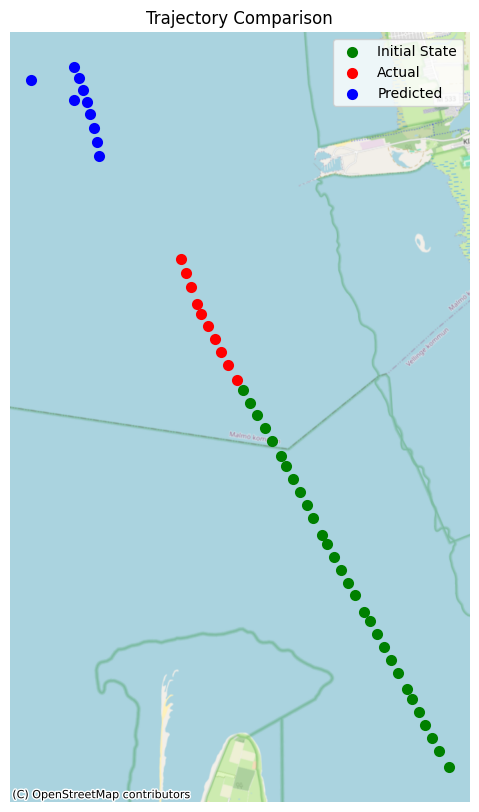

In [ ]:
predict_and_visualize_torch(model, test_loader, device, scaler, index=120, config=config, line=False)

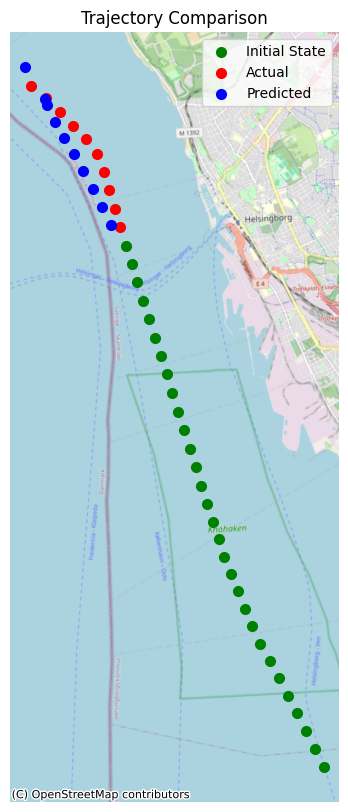

In [ ]:
predict_and_visualize_torch(model, test_loader, device, scaler, index=1230, config=config, line=False)

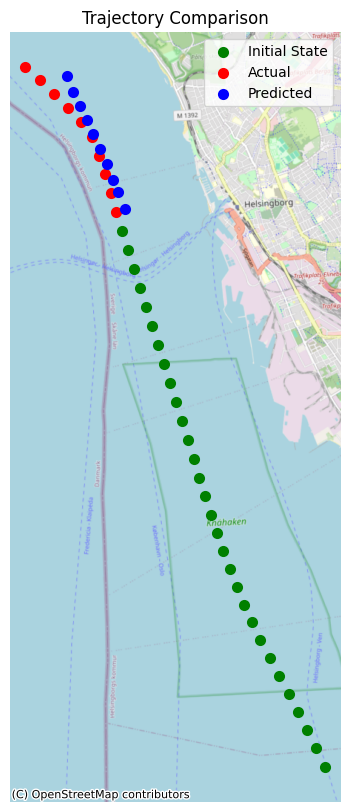

In [ ]:
predict_and_visualize_torch(model, test_loader, device, scaler, index=1230, config=config, line=False)

##### 30 windows 5 steps

In [ ]:
# Parameters
config = {
    "epochs": 50,
    "lstm_layers": 2,
    "lstm_layer_size": 250,
    "batch_size": 256,
    "dense_layer_size": 150,
    "dropout": 0.2,
    "optimizer": "adam",
    "learning_rate": 0.0005,
    "activation": "relu",
    "sequence_length": 30,
    "prediction_steps": 5,
    "num_features": 3,
    "columns": ['lat', 'lon', 'sog'],
    "group_attr": 'mmsi_id'
}
model, test_loader, scaler, epoch = train(dataset=dataset, config=config)

<ipython-input-12-125a9e403b7e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = (data[column] - self.mean[column]) / self.std[column]
  2%|▏         | 1/50 [00:04<04:03,  4.98s/it]

Epoch: 0, avg_vloss: 5.75213135948664,  best_vloss: inf


  4%|▍         | 2/50 [00:09<03:58,  4.96s/it]

Epoch: 1, avg_vloss: 2.4366316071039513,  best_vloss: 5.75213135948664


  6%|▌         | 3/50 [00:14<03:53,  4.96s/it]

Epoch: 2, avg_vloss: 1.1449199386789828,  best_vloss: 2.4366316071039513


  8%|▊         | 4/50 [00:19<03:48,  4.96s/it]

Epoch: 3, avg_vloss: 3.35869743552389,  best_vloss: 1.1449199386789828


 10%|█         | 5/50 [00:24<03:43,  4.96s/it]

Epoch: 4, avg_vloss: 1.4128417470787145,  best_vloss: 1.1449199386789828


 12%|█▏        | 6/50 [00:29<03:38,  4.97s/it]

Epoch: 5, avg_vloss: 1.0064697657959372,  best_vloss: 1.1449199386789828


 14%|█▍        | 7/50 [00:34<03:33,  4.97s/it]

Epoch: 6, avg_vloss: 1.1950374502169936,  best_vloss: 1.0064697657959372


 16%|█▌        | 8/50 [00:39<03:28,  4.97s/it]

Epoch: 7, avg_vloss: 1.688742052150678,  best_vloss: 1.0064697657959372


 18%|█▊        | 9/50 [00:44<03:23,  4.97s/it]

Epoch: 8, avg_vloss: 0.9446402705168422,  best_vloss: 1.0064697657959372


 20%|██        | 10/50 [00:49<03:18,  4.97s/it]

Epoch: 9, avg_vloss: 0.8824309948124464,  best_vloss: 0.9446402705168422


 22%|██▏       | 11/50 [00:54<03:17,  5.06s/it]

Epoch: 10, avg_vloss: 0.9648790472670447,  best_vloss: 0.8824309948124464


 24%|██▍       | 12/50 [00:59<03:11,  5.04s/it]

Epoch: 11, avg_vloss: 0.7683353899400446,  best_vloss: 0.8824309948124464


 26%|██▌       | 13/50 [01:04<03:05,  5.01s/it]

Epoch: 12, avg_vloss: 0.7652765504921539,  best_vloss: 0.7683353899400446


 28%|██▊       | 14/50 [01:09<02:59,  4.99s/it]

Epoch: 13, avg_vloss: 1.1287240001219738,  best_vloss: 0.7652765504921539


 30%|███       | 15/50 [01:14<02:54,  4.98s/it]

Epoch: 14, avg_vloss: 0.5009237086471123,  best_vloss: 0.7652765504921539


 32%|███▏      | 16/50 [01:19<02:48,  4.96s/it]

Epoch: 15, avg_vloss: 0.6956614648239522,  best_vloss: 0.5009237086471123


 34%|███▍      | 17/50 [01:24<02:43,  4.95s/it]

Epoch: 16, avg_vloss: 0.8210196932659873,  best_vloss: 0.5009237086471123


 36%|███▌      | 18/50 [01:29<02:38,  4.95s/it]

Epoch: 17, avg_vloss: 0.6165694334084475,  best_vloss: 0.5009237086471123


 38%|███▊      | 19/50 [01:34<02:33,  4.95s/it]

Epoch: 18, avg_vloss: 0.9674119179761862,  best_vloss: 0.5009237086471123


 40%|████      | 20/50 [01:39<02:28,  4.94s/it]

Epoch: 19, avg_vloss: 0.8149409094188786,  best_vloss: 0.5009237086471123


 42%|████▏     | 21/50 [01:44<02:23,  4.94s/it]

Epoch: 20, avg_vloss: 0.9486076318764989,  best_vloss: 0.5009237086471123


 44%|████▍     | 22/50 [01:49<02:18,  4.94s/it]

Epoch: 21, avg_vloss: 0.5667808806594414,  best_vloss: 0.5009237086471123


 46%|████▌     | 23/50 [01:54<02:16,  5.05s/it]

Epoch: 22, avg_vloss: 0.4478133720687673,  best_vloss: 0.5009237086471123


 48%|████▊     | 24/50 [01:59<02:10,  5.02s/it]

Epoch: 23, avg_vloss: 0.4747191988214662,  best_vloss: 0.4478133720687673


 50%|█████     | 25/50 [02:04<02:04,  5.00s/it]

Epoch: 24, avg_vloss: 0.4778147894370405,  best_vloss: 0.4478133720687673


 52%|█████▏    | 26/50 [02:09<01:59,  4.98s/it]

Epoch: 25, avg_vloss: 0.5548733208752885,  best_vloss: 0.4478133720687673


 54%|█████▍    | 27/50 [02:14<01:54,  4.97s/it]

Epoch: 26, avg_vloss: 0.4117321387121949,  best_vloss: 0.4478133720687673


 56%|█████▌    | 28/50 [02:19<01:49,  4.97s/it]

Epoch: 27, avg_vloss: 0.7484836593458924,  best_vloss: 0.4117321387121949


 58%|█████▊    | 29/50 [02:24<01:44,  4.96s/it]

Epoch: 28, avg_vloss: 0.40346879861022855,  best_vloss: 0.4117321387121949


 60%|██████    | 30/50 [02:29<01:39,  4.96s/it]

Epoch: 29, avg_vloss: 0.8425469390953644,  best_vloss: 0.40346879861022855


 62%|██████▏   | 31/50 [02:34<01:34,  4.96s/it]

Epoch: 30, avg_vloss: 0.4633144110063963,  best_vloss: 0.40346879861022855


 64%|██████▍   | 32/50 [02:39<01:29,  4.96s/it]

Epoch: 31, avg_vloss: 0.5204889555520649,  best_vloss: 0.40346879861022855


 66%|██████▌   | 33/50 [02:44<01:24,  4.95s/it]

Epoch: 32, avg_vloss: 1.0389154809939711,  best_vloss: 0.40346879861022855


 68%|██████▊   | 34/50 [02:49<01:20,  5.05s/it]

Epoch: 33, avg_vloss: 0.5095043827461291,  best_vloss: 0.40346879861022855


 70%|███████   | 35/50 [02:54<01:15,  5.02s/it]

Epoch: 34, avg_vloss: 0.6396440192113949,  best_vloss: 0.40346879861022855


 72%|███████▏  | 36/50 [02:59<01:09,  5.00s/it]

Epoch: 35, avg_vloss: 0.7239479897897455,  best_vloss: 0.40346879861022855


 74%|███████▍  | 37/50 [03:04<01:04,  4.98s/it]

Epoch: 36, avg_vloss: 0.7553099940849256,  best_vloss: 0.40346879861022855


 76%|███████▌  | 38/50 [03:09<00:59,  4.97s/it]

Epoch: 37, avg_vloss: 0.495894840623759,  best_vloss: 0.40346879861022855


 78%|███████▊  | 39/50 [03:14<00:54,  4.97s/it]

Epoch: 38, avg_vloss: 0.35752931557878664,  best_vloss: 0.40346879861022855


 78%|███████▊  | 39/50 [03:19<00:56,  5.10s/it]

Epoch: 39, avg_vloss: 0.7222942725012574,  best_vloss: 0.35752931557878664


batch loss,█▄▂▂▂▁▁▂▂▁▁▂▂▂▁▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▂▂▁▁▂▁▂▁
best_loss,█▄▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▅▂▂▂▃▂▂▂▂▂▂▁▁▂▁▂▂▂▁▁▁▁▁▁▂▁▂▁▁▂▁▁▁▂▁▁▁
batch loss,6.74524
best_loss,0.35753
epoch,39
loss,0.72229


In [ ]:
# Get predictions and labels
predictions, all_inputs, all_labels = predict_and_compare(model, test_loader, device, config)
evaluate_model(predictions, all_labels, config, scaler, evaluation)
evaluation["Epoch"].append(epoch)
print(evaluation)

<ipython-input-96-95384094d90a>:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(predictions, dtype=torch.float32)
<ipython-input-96-95384094d90a>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)


Input Windows,▁
MAE,▁
MAPE,▁
MSE,▁
Mean Distance,▁
Prediction Steps,▁
RMSE,▁
Input Windows,30
MAE,0.0014
MAPE,0.01269
MSE,0.0


{'sequence_length': [30, 30], 'prediction_steps': [10, 5], 'MSE': [8.031380028259017e-06, 3.7769353161963147e-06], 'RMSE': [0.0028339689532983626, 0.0019434338980773992], 'MAE': [0.002031516240764311, 0.0013977361134299116], 'MAPE': [0.02416589183853413, 0.012692240317499793], 'Mean Distance': [0.5067636966705322, 0.3578170835971832], 'Epoch': [49, 31]}


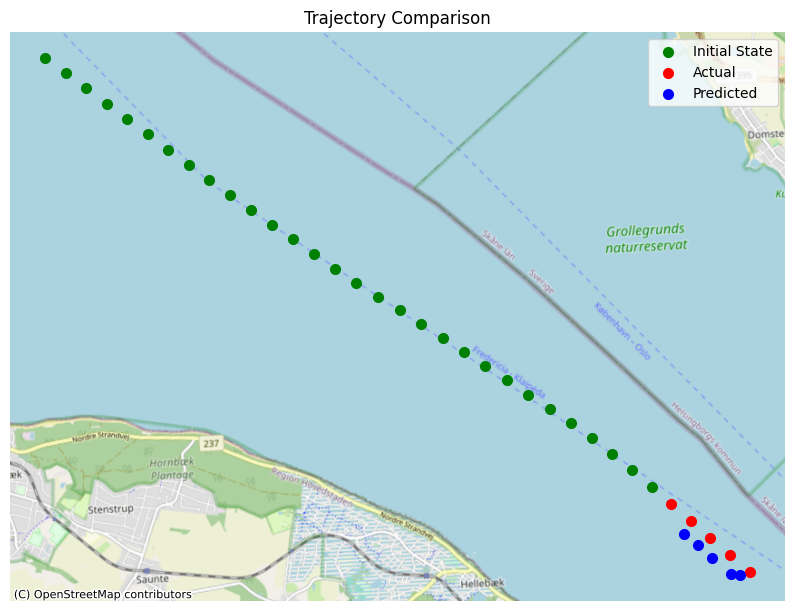

In [ ]:
predict_and_visualize_torch(model, test_loader, device, scaler, index=11233, config=config, line=False)

#### 30 windows 1 steps

In [ ]:
# Parameters
config = {
    "epochs": 100,
    "lstm_layers": 2,
    "lstm_layer_size": 250,
    "batch_size": 256,
    "dense_layer_size": 150,
    "dropout": 0.2,
    "optimizer": "adam",
    "learning_rate": 0.0005,
    "activation": "relu",
    "sequence_length": 30,
    "prediction_steps": 1,
    "num_features": 3,
    "columns": ['lat', 'lon', 'sog'],
    "group_attr": 'mmsi_id'
}
model, test_loader, scaler, epoch = train(dataset=dataset, config=config)

<ipython-input-12-125a9e403b7e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = (data[column] - self.mean[column]) / self.std[column]
  1%|          | 1/100 [00:04<08:14,  5.00s/it]

Epoch: 0, avg_vloss: 2.8614338099956513,  best_vloss: inf


  2%|▏         | 2/100 [00:09<08:08,  4.98s/it]

Epoch: 1, avg_vloss: 1.3821141451597214,  best_vloss: 2.8614338099956513


  3%|▎         | 3/100 [00:14<08:02,  4.98s/it]

Epoch: 2, avg_vloss: 2.056604766845703,  best_vloss: 1.3821141451597214


  4%|▍         | 4/100 [00:19<07:59,  5.00s/it]

Epoch: 3, avg_vloss: 2.5926792502403258,  best_vloss: 1.3821141451597214


  5%|▌         | 5/100 [00:25<07:57,  5.03s/it]

Epoch: 4, avg_vloss: 0.9366402000188827,  best_vloss: 1.3821141451597214


  6%|▌         | 6/100 [00:30<07:54,  5.05s/it]

Epoch: 5, avg_vloss: 0.5595498863607645,  best_vloss: 0.9366402000188827


  7%|▋         | 7/100 [00:35<07:50,  5.06s/it]

Epoch: 6, avg_vloss: 0.6698626440018416,  best_vloss: 0.5595498863607645


  8%|▊         | 8/100 [00:40<07:45,  5.06s/it]

Epoch: 7, avg_vloss: 0.6295066103339195,  best_vloss: 0.5595498863607645


  9%|▉         | 9/100 [00:45<07:41,  5.07s/it]

Epoch: 8, avg_vloss: 1.364391753077507,  best_vloss: 0.5595498863607645


 10%|█         | 10/100 [00:50<07:35,  5.07s/it]

Epoch: 9, avg_vloss: 0.42567306458950044,  best_vloss: 0.5595498863607645


 11%|█         | 11/100 [00:55<07:37,  5.15s/it]

Epoch: 10, avg_vloss: 0.4999562703073025,  best_vloss: 0.42567306458950044


 12%|█▏        | 12/100 [01:00<07:29,  5.11s/it]

Epoch: 11, avg_vloss: 0.42162837982177737,  best_vloss: 0.42567306458950044


 13%|█▎        | 13/100 [01:05<07:21,  5.08s/it]

Epoch: 12, avg_vloss: 0.8336500808596611,  best_vloss: 0.42162837982177737


 14%|█▍        | 14/100 [01:10<07:13,  5.04s/it]

Epoch: 13, avg_vloss: 0.3857984371483326,  best_vloss: 0.42162837982177737


 15%|█▌        | 15/100 [01:15<07:05,  5.01s/it]

Epoch: 14, avg_vloss: 0.3787068836390972,  best_vloss: 0.3857984371483326


 16%|█▌        | 16/100 [01:20<06:59,  4.99s/it]

Epoch: 15, avg_vloss: 0.634619877487421,  best_vloss: 0.3787068836390972


 17%|█▋        | 17/100 [01:25<06:54,  5.00s/it]

Epoch: 16, avg_vloss: 0.6154944807291031,  best_vloss: 0.3787068836390972


 18%|█▊        | 18/100 [01:30<06:49,  4.99s/it]

Epoch: 17, avg_vloss: 0.4514310609549284,  best_vloss: 0.3787068836390972


 19%|█▉        | 19/100 [01:35<06:44,  5.00s/it]

Epoch: 18, avg_vloss: 1.4381208077073098,  best_vloss: 0.3787068836390972


 20%|██        | 20/100 [01:40<06:40,  5.00s/it]

Epoch: 19, avg_vloss: 0.7257257468998433,  best_vloss: 0.3787068836390972


 21%|██        | 21/100 [01:45<06:42,  5.10s/it]

Epoch: 20, avg_vloss: 1.44589321911335,  best_vloss: 0.3787068836390972


 22%|██▏       | 22/100 [01:50<06:36,  5.08s/it]

Epoch: 21, avg_vloss: 0.5114535726606846,  best_vloss: 0.3787068836390972


 23%|██▎       | 23/100 [01:56<06:30,  5.07s/it]

Epoch: 22, avg_vloss: 0.5302715320140123,  best_vloss: 0.3787068836390972


 24%|██▍       | 24/100 [02:01<06:24,  5.07s/it]

Epoch: 23, avg_vloss: 1.0596707142889499,  best_vloss: 0.3787068836390972


 25%|██▌       | 25/100 [02:06<06:18,  5.04s/it]

Epoch: 24, avg_vloss: 1.66261028945446,  best_vloss: 0.3787068836390972


 26%|██▌       | 26/100 [02:11<06:13,  5.04s/it]

Epoch: 25, avg_vloss: 0.783865287154913,  best_vloss: 0.3787068836390972


 27%|██▋       | 27/100 [02:16<06:07,  5.03s/it]

Epoch: 26, avg_vloss: 0.5107406567782163,  best_vloss: 0.3787068836390972


 28%|██▊       | 28/100 [02:21<06:01,  5.02s/it]

Epoch: 27, avg_vloss: 0.47137230448424816,  best_vloss: 0.3787068836390972


 29%|██▉       | 29/100 [02:26<05:56,  5.03s/it]

Epoch: 28, avg_vloss: 0.5464337144047022,  best_vloss: 0.3787068836390972


 30%|███       | 30/100 [02:31<05:52,  5.03s/it]

Epoch: 29, avg_vloss: 0.5850167807191611,  best_vloss: 0.3787068836390972


 30%|███       | 30/100 [02:36<06:04,  5.21s/it]

Epoch: 30, avg_vloss: 0.6818258557468653,  best_vloss: 0.3787068836390972


batch loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_loss,█▄▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▄▆▇▃▂▂▂▄▁▁▁▂▁▁▂▂▁▄▂▄▁▁▃▅▂▁▁▁▂▂
batch loss,6.19494
best_loss,0.37871
epoch,30
loss,0.68183


In [ ]:
# Get predictions and labels
predictions, all_inputs, all_labels = predict_and_compare(model, test_loader, device, config)
evaluate_model(predictions, all_labels, config, scaler, evaluation)
evaluation["Epoch"].append(epoch)
print(evaluation)

<ipython-input-96-95384094d90a>:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(predictions, dtype=torch.float32)
<ipython-input-96-95384094d90a>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)


Input Windows,▁
MAE,▁
MAPE,▁
MSE,▁
Mean Distance,▁
Prediction Steps,▁
RMSE,▁
Input Windows,30
MAE,0.00201
MAPE,0.02347
MSE,1e-05


{'sequence_length': [30, 30, 30], 'prediction_steps': [10, 5, 1], 'MSE': [8.031380028259017e-06, 3.7769353161963147e-06, 6.05407139078925e-06], 'RMSE': [0.0028339689532983626, 0.0019434338980773992, 0.0024605022639268693], 'MAE': [0.002031516240764311, 0.0013977361134299116, 0.002012691890331934], 'MAPE': [0.02416589183853413, 0.012692240317499793, 0.02347394640595242], 'Mean Distance': [0.5067636966705322, 0.3578170835971832, 0.4890483021736145], 'Epoch': [49, 31, 30]}


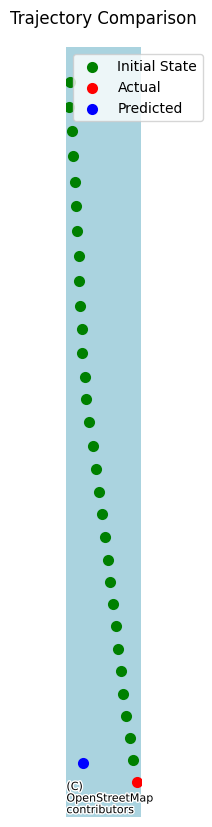

In [ ]:
predict_and_visualize_torch(model, test_loader, device, scaler, index=12300, config=config, line=False)

##### 30 windows 20 steps

In [ ]:
# Filter dataset to get minimum number of points for training
dataset = dataset.groupby('mmsi_id').filter(lambda x: len(x) >= 50)
dataset.count()

t               113821
mmsi_id         113821
trip            113821
sog             113821
cog             113821
delta_t         113821
cog_rad         113821
cog_x           113821
cog_y           113821
lat             113821
lon             113821
prev_lat        113320
prev_lon        113320
lat_rad         113821
lon_rad         113821
prev_lat_rad    113320
prev_lon_rad    113320
gaps            113821
dtype: int64

In [ ]:
# Parameters
config = {
    "epochs": 25,
    "lstm_layers": 2,
    "lstm_layer_size": 250,
    "batch_size": 256,
    "dense_layer_size": 150,
    "dropout": 0.2,
    "optimizer": "adam",
    "learning_rate": 0.005,
    "activation": "relu",
    "sequence_length": 30,
    "prediction_steps": 20,
    "num_features": 3,
    "columns": ['lat', 'lon', 'sog'],
    "group_attr": 'mmsi_id'
}
model, test_loader, scaler, epoch = train(dataset=dataset, config=config)

<ipython-input-12-125a9e403b7e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = (data[column] - self.mean[column]) / self.std[column]
  4%|▍         | 1/25 [00:04<01:45,  4.40s/it]

Epoch: 0, avg_vloss: 63469.304630867424,  best_vloss: inf


  8%|▊         | 2/25 [00:08<01:41,  4.39s/it]

Epoch: 1, avg_vloss: 63414.29272698049,  best_vloss: 63469.304630867424


 12%|█▏        | 3/25 [00:13<01:39,  4.54s/it]

Epoch: 2, avg_vloss: 63423.433447857424,  best_vloss: 63414.29272698049


 16%|█▌        | 4/25 [00:17<01:34,  4.50s/it]

Epoch: 3, avg_vloss: 63414.177534207905,  best_vloss: 63414.29272698049


 20%|██        | 5/25 [00:22<01:29,  4.49s/it]

Epoch: 4, avg_vloss: 63422.33892686563,  best_vloss: 63414.177534207905


 24%|██▍       | 6/25 [00:26<01:25,  4.48s/it]

Epoch: 5, avg_vloss: 63423.7645139237,  best_vloss: 63414.177534207905


 28%|██▊       | 7/25 [00:31<01:20,  4.49s/it]

Epoch: 6, avg_vloss: 63440.55238582663,  best_vloss: 63414.177534207905


 32%|███▏      | 8/25 [00:35<01:16,  4.48s/it]

Epoch: 7, avg_vloss: 63424.69624644763,  best_vloss: 63414.177534207905


 36%|███▌      | 9/25 [00:40<01:11,  4.48s/it]

Epoch: 8, avg_vloss: 63427.40391191718,  best_vloss: 63414.177534207905


 40%|████      | 10/25 [00:44<01:07,  4.48s/it]

Epoch: 9, avg_vloss: 63438.47295906119,  best_vloss: 63414.177534207905


 44%|████▍     | 11/25 [00:49<01:02,  4.47s/it]

Epoch: 10, avg_vloss: 63434.8800644352,  best_vloss: 63414.177534207905


 48%|████▊     | 12/25 [00:53<00:57,  4.46s/it]

Epoch: 11, avg_vloss: 63437.9276562129,  best_vloss: 63414.177534207905


 52%|█████▏    | 13/25 [00:58<00:53,  4.46s/it]

Epoch: 12, avg_vloss: 63437.14816179994,  best_vloss: 63414.177534207905


 56%|█████▌    | 14/25 [01:02<00:48,  4.45s/it]

Epoch: 13, avg_vloss: 63453.67469442707,  best_vloss: 63414.177534207905


 60%|██████    | 15/25 [01:07<00:45,  4.52s/it]

Epoch: 14, avg_vloss: 63455.367606376945,  best_vloss: 63414.177534207905


 64%|██████▍   | 16/25 [01:11<00:40,  4.49s/it]

Epoch: 15, avg_vloss: 63449.178679623015,  best_vloss: 63414.177534207905


 68%|██████▊   | 17/25 [01:16<00:35,  4.46s/it]

Epoch: 16, avg_vloss: 63447.58899554815,  best_vloss: 63414.177534207905


 72%|███████▏  | 18/25 [01:20<00:31,  4.43s/it]

Epoch: 17, avg_vloss: 63453.79779493646,  best_vloss: 63414.177534207905


 76%|███████▌  | 19/25 [01:24<00:26,  4.44s/it]

Epoch: 18, avg_vloss: 63463.78706685484,  best_vloss: 63414.177534207905


 80%|████████  | 20/25 [01:29<00:22,  4.45s/it]

Epoch: 19, avg_vloss: 63449.0890447081,  best_vloss: 63414.177534207905


 84%|████████▍ | 21/25 [01:33<00:17,  4.44s/it]

Epoch: 20, avg_vloss: 63458.663214288346,  best_vloss: 63414.177534207905


 88%|████████▊ | 22/25 [01:38<00:13,  4.45s/it]

Epoch: 21, avg_vloss: 63462.53475557615,  best_vloss: 63414.177534207905


 92%|█████████▏| 23/25 [01:42<00:08,  4.43s/it]

Epoch: 22, avg_vloss: 63462.13743117574,  best_vloss: 63414.177534207905


 96%|█████████▌| 24/25 [01:47<00:04,  4.45s/it]

Epoch: 23, avg_vloss: 63467.97091415484,  best_vloss: 63414.177534207905


100%|██████████| 25/25 [01:51<00:00,  4.46s/it]

Epoch: 24, avg_vloss: 63471.07499863024,  best_vloss: 63414.177534207905


batch loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▂▁▂▂▄▂▃▄▄▄▄▆▆▅▅▆▇▅▆▇▇██
batch loss,7.0902
best_loss,63414.17753
epoch,24
loss,63471.075


In [ ]:
# Get predictions and labels
predictions, all_inputs, all_labels = predict_and_compare(model, test_loader, device, config)
evaluate_model(predictions, all_labels, config, scaler, evaluation)
evaluation["Epoch"].append(epoch)
print(evaluation)

<ipython-input-96-95384094d90a>:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(predictions, dtype=torch.float32)
<ipython-input-96-95384094d90a>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)


Input Windows,▁
MAE,▁
MAPE,▁
MSE,▁
Mean Distance,▁
Prediction Steps,▁
RMSE,▁
Input Windows,30
MAE,0.00498
MAPE,0.05828
MSE,4e-05


{'sequence_length': [30, 30, 30, 30], 'prediction_steps': [10, 5, 1, 20], 'MSE': [8.031380028259017e-06, 3.7769353161963147e-06, 6.05407139078925e-06, 4.3601348105918275e-05], 'RMSE': [0.0028339689532983626, 0.0019434338980773992, 0.0024605022639268693, 0.0066031316892757996], 'MAE': [0.002031516240764311, 0.0013977361134299116, 0.002012691890331934, 0.004983621401254147], 'MAPE': [0.02416589183853413, 0.012692240317499793, 0.02347394640595242, 0.05827727323665456], 'Mean Distance': [0.5067636966705322, 0.3578170835971832, 0.4890483021736145, 1.2429536581039429], 'Epoch': [49, 31, 30, 24]}


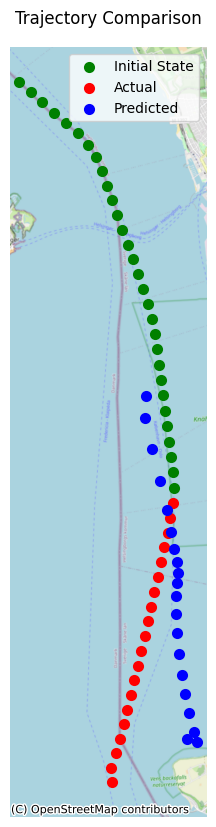

In [ ]:
predict_and_visualize_torch(model, test_loader, device, scaler, index=1200, config=config, line=False)

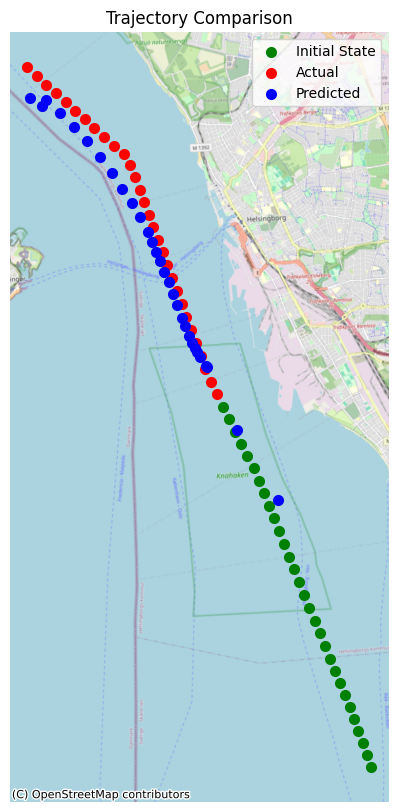

In [ ]:
predict_and_visualize_torch(model, test_loader, device, scaler, index=4003, config=config, line=False)

##### 30 minutes 30  minutes

In [ ]:
# Filter dataset to get minimum number of points for training
dataset = dataset.groupby('mmsi_id').filter(lambda x: len(x) >= 60)
dataset.count()

t               110865
mmsi_id         110865
trip            110865
sog             110865
cog             110865
delta_t         110865
cog_rad         110865
cog_x           110865
cog_y           110865
lat             110865
lon             110865
prev_lat        110419
prev_lon        110419
lat_rad         110865
lon_rad         110865
prev_lat_rad    110419
prev_lon_rad    110419
gaps            110865
dtype: int64

In [ ]:
# Parameters
config = {
    "epochs": 25,
    "lstm_layers": 2,
    "lstm_layer_size": 250,
    "batch_size": 256,
    "dense_layer_size": 150,
    "dropout": 0.2,
    "optimizer": "adam",
    "learning_rate": 0.0005,
    "activation": "relu",
    "sequence_length": 30,
    "prediction_steps": 30,
    "num_features": 3,
    "columns": ['lat', 'lon', 'sog'],
    "group_attr": 'mmsi_id'
}
model, test_loader, scaler, epoch = train(dataset=dataset, config=config)

<ipython-input-12-125a9e403b7e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = (data[column] - self.mean[column]) / self.std[column]
  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0, avg_vloss: 60.10372543334961,  best_vloss: inf


  8%|▊         | 2/25 [00:09<01:49,  4.77s/it]

Epoch: 1, avg_vloss: 31.879037576563217,  best_vloss: 60.10372543334961


 12%|█▏        | 3/25 [00:14<01:39,  4.53s/it]

Epoch: 2, avg_vloss: 24.307326120488785,  best_vloss: 31.879037576563217


 16%|█▌        | 4/25 [00:18<01:32,  4.42s/it]

Epoch: 3, avg_vloss: 22.444305672365076,  best_vloss: 24.307326120488785


 20%|██        | 5/25 [00:22<01:29,  4.47s/it]

Epoch: 4, avg_vloss: 19.533969710854922,  best_vloss: 22.444305672365076


 24%|██▍       | 6/25 [00:27<01:23,  4.40s/it]

Epoch: 5, avg_vloss: 18.657067144618313,  best_vloss: 19.533969710854922


 28%|██▊       | 7/25 [00:31<01:18,  4.35s/it]

Epoch: 6, avg_vloss: 18.88924339238335,  best_vloss: 18.657067144618313


 32%|███▏      | 8/25 [00:35<01:13,  4.32s/it]

Epoch: 7, avg_vloss: 17.344122381771314,  best_vloss: 18.657067144618313


 36%|███▌      | 9/25 [00:39<01:08,  4.30s/it]

Epoch: 8, avg_vloss: 17.26452990139232,  best_vloss: 17.344122381771314


 40%|████      | 10/25 [00:44<01:04,  4.28s/it]

Epoch: 9, avg_vloss: 14.540631995481604,  best_vloss: 17.26452990139232


 44%|████▍     | 11/25 [00:48<00:59,  4.27s/it]

Epoch: 10, avg_vloss: 14.27727369701161,  best_vloss: 14.540631995481604


 48%|████▊     | 12/25 [00:52<00:55,  4.26s/it]

Epoch: 11, avg_vloss: 14.102648889317232,  best_vloss: 14.27727369701161


 52%|█████▏    | 13/25 [00:56<00:51,  4.25s/it]

Epoch: 12, avg_vloss: 13.69776694914874,  best_vloss: 14.102648889317232


 56%|█████▌    | 14/25 [01:01<00:46,  4.25s/it]

Epoch: 13, avg_vloss: 13.140888354357552,  best_vloss: 13.69776694914874


 60%|██████    | 15/25 [01:05<00:42,  4.24s/it]

Epoch: 14, avg_vloss: 12.654441777397604,  best_vloss: 13.140888354357552


 64%|██████▍   | 16/25 [01:09<00:38,  4.23s/it]

Epoch: 15, avg_vloss: 12.864328160005456,  best_vloss: 12.654441777397604


 68%|██████▊   | 17/25 [01:13<00:33,  4.22s/it]

Epoch: 16, avg_vloss: 12.772541018093333,  best_vloss: 12.654441777397604


 72%|███████▏  | 18/25 [01:18<00:30,  4.30s/it]

Epoch: 17, avg_vloss: 11.578555387609144,  best_vloss: 12.654441777397604


 76%|███████▌  | 19/25 [01:22<00:25,  4.28s/it]

Epoch: 18, avg_vloss: 11.597222882158617,  best_vloss: 11.578555387609144


 80%|████████  | 20/25 [01:26<00:21,  4.26s/it]

Epoch: 19, avg_vloss: 11.85601801030776,  best_vloss: 11.578555387609144


 84%|████████▍ | 21/25 [01:30<00:17,  4.25s/it]

Epoch: 20, avg_vloss: 11.02404497651493,  best_vloss: 11.578555387609144


 88%|████████▊ | 22/25 [01:35<00:12,  4.25s/it]

Epoch: 21, avg_vloss: 10.48518729911131,  best_vloss: 11.02404497651493


 92%|█████████▏| 23/25 [01:39<00:08,  4.24s/it]

Epoch: 22, avg_vloss: 10.420546721009647,  best_vloss: 10.48518729911131


 96%|█████████▌| 24/25 [01:43<00:04,  4.24s/it]

Epoch: 23, avg_vloss: 11.167767763137817,  best_vloss: 10.420546721009647


100%|██████████| 25/25 [01:47<00:00,  4.31s/it]

Epoch: 24, avg_vloss: 10.04773114008062,  best_vloss: 10.420546721009647


batch loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
batch loss,10.72416
best_loss,10.04773
epoch,24
loss,10.04773


In [ ]:
# Get predictions and labels
predictions, all_inputs, all_labels = predict_and_compare(model, test_loader, device, config)
evaluate_model(predictions, all_labels, config, scaler, evaluation)
evaluation["Epoch"].append(epoch)
print(evaluation)

<ipython-input-96-95384094d90a>:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(predictions, dtype=torch.float32)
<ipython-input-96-95384094d90a>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)


Input Windows,▁
MAE,▁
MAPE,▁
MSE,▁
Mean Distance,▁
Prediction Steps,▁
RMSE,▁
Input Windows,30
MAE,0.00612
MAPE,0.06848
MSE,9e-05


{'sequence_length': [30, 30, 30, 30, 30], 'prediction_steps': [10, 5, 1, 20, 30], 'MSE': [8.031380028259017e-06, 3.7769353161963147e-06, 6.05407139078925e-06, 4.3601348105918275e-05, 9.052913656404242e-05], 'RMSE': [0.0028339689532983626, 0.0019434338980773992, 0.0024605022639268693, 0.0066031316892757996, 0.009514680055789707], 'MAE': [0.002031516240764311, 0.0013977361134299116, 0.002012691890331934, 0.004983621401254147, 0.006122629613654539], 'MAPE': [0.02416589183853413, 0.012692240317499793, 0.02347394640595242, 0.05827727323665456, 0.06847989400202145], 'Mean Distance': [0.5067636966705322, 0.3578170835971832, 0.4890483021736145, 1.2429536581039429, 1.5383268594741821], 'Epoch': [49, 31, 30, 24, 24]}


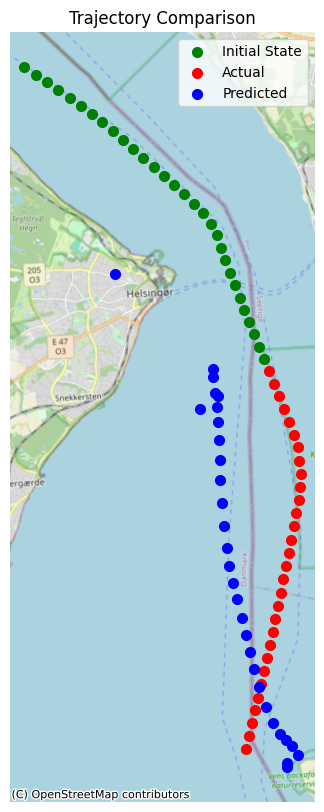

In [ ]:
predict_and_visualize_torch(model, test_loader, device, scaler, index=1200, config=config, line=False)

In [ ]:
evaluation_df = pd.DataFrame(evaluation)
evaluation_df.to_csv('evaluation_results.csv', index=False)

In [ ]:
evaluation_df['MAPE'] = evaluation_df['MAPE'] * 100

In [ ]:
evaluation_df.sort_values(by=['prediction_steps'], inplace=True)

In [ ]:
evaluation_df

,sequence_length,prediction_steps,MSE,RMSE,MAE,MAPE,Mean Distance,Epoch
2,30,1,0.000006,0.002461,0.002013,2.347395,0.489048,30
1,30,5,0.000004,0.001943,0.001398,1.269224,0.357817,31
0,30,10,0.000008,0.002834,0.002032,2.416589,0.506764,49
3,30,20,0.000044,0.006603,0.004984,5.827727,1.242954,24
4,30,30,0.000091,0.009515,0.006123,6.847989,1.538327,24
